<a href="https://colab.research.google.com/github/andysun-1997/Create-Bell-state/blob/master/Create_Bell_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 17kB/s 
     |████████████████████████████████| 450kB 42.0MB/s 
     |████████████████████████████████| 3.9MB 42.6MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=6d416bf11218735fc0022f923551341dd1c4d22bf6ff6b9b56f90b63b6cc11af
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
!pip install tensorflow-quantum

     |████████████████████████████████| 3.9MB 14.5MB/s 
     |████████████████████████████████| 1.4MB 44.4MB/s 
     |████████████████████████████████| 163kB 47.1MB/s 
     |████████████████████████████████| 5.3MB 44.4MB/s 
     |████████████████████████████████| 1.2MB 40.8MB/s 
     |████████████████████████████████| 112kB 44.3MB/s 
     |████████████████████████████████| 133kB 38.7MB/s 
  Created wheel for pathos: filename=pathos-0.2.5-cp36-none-any.whl size=77577 sha256=592e846f677501531d25e6c00a1aeed6f581125861e9c1ca6450a92a850156ba
  Stored in directory: /root/.cache/pip/wheels/61/6d/83/90b0c3d2c271da2c4850731e894798c98f8dbedbac74e8eff0
  Created wheel for ppft: filename=ppft-1.6.6.2-cp36-none-any.whl size=64743 sha256=397dafa18f71383b6fdfc63ddc0d85f7a2f0165244c2b91e073c22ba36dbcd04
  Stored in directory: /root/.cache/pip/wheels/db/d2/2d/0ee21ede61786bb13247dbc69079373fd500c2bb0481913084
  Created wheel for pox: filename=pox-0.2.8-cp36-none-any.whl size=28290 sha256=adae928f3e709e

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
# variables
symbols = sympy.symbols('a b c d')

In [ ]:
# create qubits
q0, q1 = cirq.LineQubit.range(2)

In [ ]:
# create variational circuit
def get_var_form(symbols):
  circuit = cirq.Circuit(
    cirq.rx(symbols[0]).on(q0),
    cirq.rx(symbols[1]).on(q1), 
    cirq.ry(symbols[2]).on(q0),
    cirq.ry(symbols[3]).on(q1),
    # Monte Carlo Simulation of Noise
    cirq.bit_flip(p=0.02)(q0),
    cirq.bit_flip(p=0.02)(q1), 
    cirq.CNOT(control=q0, target=q1),
    #cirq.measure(q0, q1, key='result')
    )
  return circuit

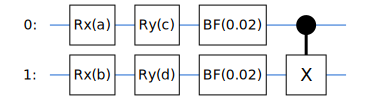

In [ ]:
# Circuit Visualization
circuit = get_var_form(symbols)
SVGCircuit(circuit)

In [ ]:
simulator = cirq.Simulator()
#initialize parameters to all 0's
params = [0] * 4
params = tf.convert_to_tensor(
    params, dtype=tf.float32, dtype_hint=None, name=None
)
print('starting parameters:')
print(params)
param0, param1, param2, param3 = 0, 0, 0, 0 
# number of measurements
reps = 1000
# loss function
def loss(params):
  qc = get_var_form(symbols)
  qc.append(cirq.measure(q0, q1, key='result'))
  resolver = cirq.ParamResolver({symbols[0]: params[0], symbols[1]: params[1], symbols[2]: params[2], symbols[3]: params[3]})
  results = simulator.run(qc, resolver, repetitions=reps)
  counter = results.histogram(key='result')
  # loss as euclidean distance to (1/2, 1/2)
  loss = (counter[1]/reps - 0.5)**2 + (counter[2]/reps - 0.5)**2
  '''loss = tf.convert_to_tensor(
    loss, dtype=tf.float32)'''
  return loss
l = loss(params)
print('starting loss:' + str(l))
#print(counter)

starting parameters:
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
starting loss:0.48229


In [ ]:
#optimize
from scipy.optimize import minimize
from scipy import optimize

res = minimize(loss, params, method='COBYLA', tol=0.001) ## COBYLA # powell # Nelder-Mead # BFGS
print(res)

     fun: 0.0029839999999999997
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 45
  status: 1
 success: True
       x: array([-0.46869939,  2.90095149,  1.56081138, -0.04495064])


In [ ]:
#verify result
resolver = cirq.ParamResolver({symbols[0]: res.x[0], symbols[1]: res.x[1], symbols[2]: res.x[2], symbols[3]: res.x[3]})
qc = get_var_form(symbols)
qc.append(cirq.measure(q0, q1, key='result'))
results = simulator.run(qc, resolver, repetitions=reps)
counter = results.histogram(key='result')
loss = (counter[1]/reps - 0.5)**2 + (counter[2]/reps - 0.5)**2
print(counter)
print('loss: ' + str(loss))

# get state vector
qc0 = get_var_form(symbols)
state = simulator.simulate(qc0, resolver).final_state
print('state vector: ')
print(state)

Counter({1: 503, 2: 463, 0: 23, 3: 11})
loss: 0.0013779999999999984
state vector: 
[ 0.07929946-0.03502653j -0.1640182 -0.6855923j   0.16193493-0.67966205j
  0.08580209+0.00453368j]


*   High number of measurements makes the result more accurate
*   To produce exactly the state |01> + |10>, I think we need to access the final state vector instead of sampling from the final state     



